In [1]:
from itertools import islice

import torch
from torch.nn import Linear
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg11_bn, vgg11, resnet18

from zennit.attribution import Gradient, SmoothGrad
from zennit.core import Stabilizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.composites import SpecialFirstLayerMapComposite, NameMapComposite
from zennit.image import imgify, imsave
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat
from zennit.types import Convolution, Activation, AvgPool, Linear as AnyLinear
from zennit.types import BatchNorm, MaxPool
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

import numpy as np

from matplotlib import pyplot as plt

from datetime import datetime

In [2]:
from torchvision import transforms

from torch.nn import functional as F

In [3]:
import sys

In [4]:
sys.path.append("..")

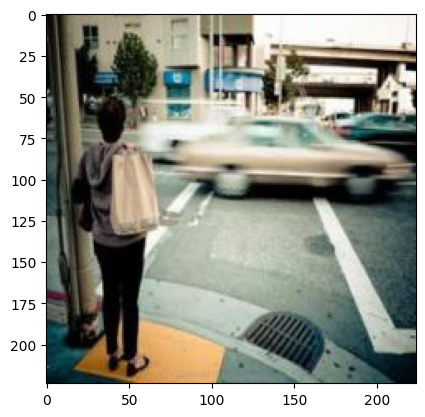

In [5]:
from imageio.v2 import imread

img = imread('../components/sample_images/000.jpg')
plt.imshow(img)

In [6]:
transform_norm = transforms.Normalize(
        mean=np.array([109.5388,118.6897,124.6901][::-1])/255,
        std=np.array([0.224]*3)
    )
transform = transforms.Compose([
    transforms.ToTensor(),
    transform_norm,
])

In [7]:
def load_model():
    
    checkpoint = torch.load("../zoo/resnet18_places365.pth.tar", map_location="cpu")

    state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}

    model = resnet18(num_classes=365)
    model.load_state_dict(state_dict)
    model.eval()
    
    return model

model = load_model()

def get_model_upto_layer4():

    model = load_model()

    model.avgpool = torch.nn.Identity()
    model.fc = torch.nn.Identity()

    return model
get_model_upto_layer4()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/pat/.cache/pypoetry/virtualenvs/ibd-Ny_6Vkke-py3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


> 112 crosswalk
> 158 gas_station
> 319 street
> 231 motel
> 270 plaza
> 257 parking_lot
> 154 fountain
> 4 alley
> 293 runway
> 255 parking_garage/indoor


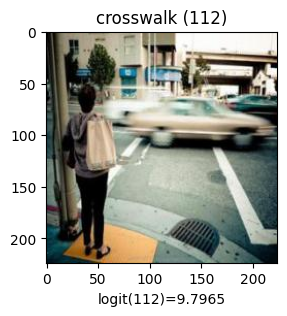

In [8]:
from util.places365_categories import places365_categories

def prediction(img):
    tsimg = transform(img)

    logits = model(tsimg.unsqueeze(0)).detach().cpu().numpy().squeeze()

    label = np.argmax(logits)

    

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    desc = places365_categories[label]
    plt.title(f"{desc} ({label})")
    plt.xlabel(f"logit({label})={logits[label]:.4f}")

    for cix in np.argsort(-logits)[:10]:
        print(f"> {cix} {places365_categories[cix]}")
    
prediction(img)

In [9]:
canonizer = ResNetCanonizer()

# the ZBox rule needs the lowest and highest values, which are here for
# ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying the canonizers, if any
composite = EpsilonGammaBox(low=low, high=high, canonizers=[canonizer])

In [10]:
def _heatmap(
    heatmap,
    title="",
    logit=None,
    reference_heatmap=None,
    total_score=None,
    grid_steps=4,
    fontsize=None,
):
    """Plot heatmap; this is adapted from https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/utils.py

    Args:
        heatmap np.array(h, w):
        reference_heatmap (np.array(h, w), optional): used for calculating normalization values. Defaults to None.
        total_score (float, optional): used for normalizing scores. Defaults to None.
    """
    assert len(heatmap.shape) == 2

    if reference_heatmap is None:
        reference_heatmap = heatmap

    assert len(reference_heatmap.shape) == 2

    b = np.abs(reference_heatmap).max()

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)

    sum_Ri = np.sum(heatmap)
    if total_score is None:
        percent = 100
        txt = r"$\sum_i R_i=%.2f$" % (sum_Ri)
    else:
        percent = (sum_Ri / total_score) * 100
        txt = r"$\sum_i R_i=%.4f$ (%3.1f%%)" % (sum_Ri, percent)

    plt.axis("on")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap, cmap=my_cmap, vmin=-b, vmax=b)

    h = heatmap.shape[0]
  
    plt.title(f"{title}", fontsize=fontsize)
    if logit is not None:
        plt.xlabel(f"{txt}, logit={logit:.4f}", fontsize=fontsize)
    else:
        plt.xlabel(f"{txt}", fontsize=fontsize)

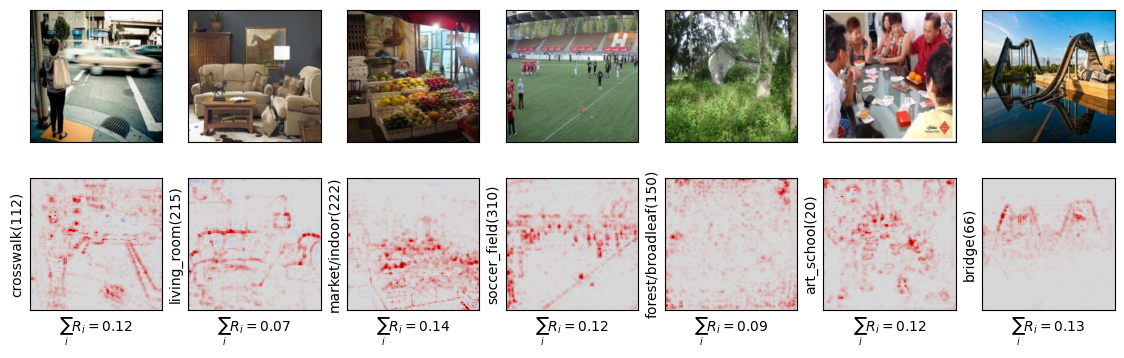

In [11]:
from matplotlib.colors import ListedColormap

def explain_images(arr_img_targets):
    TOTAL_CLASSES = 365

    ncols = len(arr_img_targets)
    nrows = 2


    plt.figure(figsize=(2*ncols, 2*nrows))

    for ix, (path, target) in enumerate(arr_img_targets):
        img = imread(path)
         
        data = transform(img).unsqueeze(0)
        
        # create the attributor, specifying model and composite
        with Gradient(model=model, composite=composite) as attributor:
            # compute the model output and attribution
            output, attribution = attributor(data, torch.eye(TOTAL_CLASSES)[[target]])
    
        heatmap = attribution.squeeze().numpy().sum(axis=0)

        plt.subplot(nrows, ncols, ix + 1)
        
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])

        plt.subplot(nrows, ncols, ncols + ix + 1)

        desc = places365_categories[target]
        _heatmap(heatmap)
        plt.ylabel(f"{desc}({target})")

    


explain_images([
    ("../components/sample_images/000.jpg", 112),
    ("../components/sample_images/005.jpg", 215),
    ("../components/sample_images/009.jpg", 222),
    ("../components/sample_images/010.jpg", 310),
    ("../components/sample_images/027.jpg", 150),
    ("../components/sample_images/045.jpg", 20),
    ("../components/sample_images/025.jpg", 66),
])

In [12]:
def load_valid_concepts():
    data = np.load("../result/pytorch_resnet18_places365/valid_concept.npy.npz", allow_pickle=True)

    valid_concepts = data["valid_concepts"]
    concept_info = data["concept_information"]

    print(f"len(valid_concepts)={len(valid_concepts)}")


    print("First 10 valid concepts")


    labels_mapping = dict() 
    concept_names = []
    for i, vid in enumerate(valid_concepts):
        _concept_info = concept_info[vid]
        _concept_name = concept_info[vid]["name"]
        if i < 10:
            print(f"> concept_id={vid}: {_concept_name}")

        labels_mapping[vid] = _concept_name
        concept_names.append(_concept_name)

    assert len(concept_names) == len(valid_concepts)
    
    return valid_concepts, concept_names, labels_mapping

valid_concepts, valid_concept_names, _ = load_valid_concepts()

len(valid_concepts)=660
First 10 valid concepts
> concept_id=12: wall
> concept_id=13: sky
> concept_id=14: floor
> concept_id=15: windowpane
> concept_id=16: tree
> concept_id=17: wood
> concept_id=18: building
> concept_id=19: person
> concept_id=21: head
> concept_id=22: leg


In [13]:
valid_concept_names[226]

'crosswalk'

In [14]:
np.argwhere(np.array(valid_concept_names) == "crosswalk")

array([[226]])

In [15]:
import os
import settings
def load_weight_concept():
    epoch = 14
    statedict = torch.load(os.path.join(settings.OUTPUT_FOLDER, "snapshot", "%d.pth" % epoch))

    weight_concept = statedict["fc.weight"].numpy()
    bias_concept=  statedict["fc.bias"].numpy()
    weight_concept = weight_concept - weight_concept.mean(1)[:, None]

    weight_concept_l2_norm = weight_concept / np.linalg.norm(weight_concept, axis=1)[:, None]
    return weight_concept_l2_norm

CAVS = load_weight_concept()

In [16]:
CAVS.shape, len(valid_concept_names)

((660, 512), 660)

In [17]:
def get_compatible_concepts_of_label(label):
    rankings, _, _, _ = np.load(
        "../result/pytorch_resnet18_places365/decompose.npy",
        allow_pickle=True
    )
    
    arr_concept_indices = rankings[label, :]
    assert arr_concept_indices.shape == (7, )
    
    print(f"----- compatible concepts of label={label} ----")
    
    for cix in arr_concept_indices:
        print(f"> cix={cix:3d}: {valid_concept_names[cix]}")
        
    return arr_concept_indices

get_compatible_concepts_of_label(112)

----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van


array([226, 210,  42, 116, 477, 248, 128], dtype=int32)

----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van


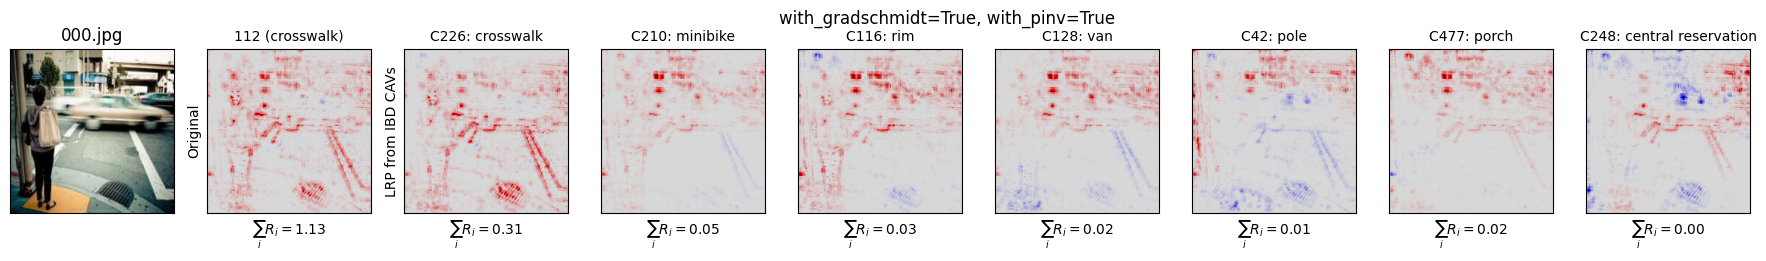

In [18]:
def logit_modifier(label: int):
    def modify(output):
        _, nc = output.shape
        one_hot = F.one_hot(torch.tensor([label]), nc).to(output.device)
        return output * one_hot

    return modify
    
def explain_with_basis(
    path, 
    target,
    with_pinv=False,
    with_gramschmidt=False
):
    TOTAL_CLASSES = 365
    img = imread(path)
  
    layer_dims = 512
    
    arr_compatible_concept_indices = get_compatible_concepts_of_label(target)
    n_concepts = len(arr_compatible_concept_indices)
  
    data = transform(img).unsqueeze(0)
    
    V = CAVS[arr_compatible_concept_indices, :]
    
    if with_gramschmidt:
        V, _ = np.linalg.qr(V.T)
    else:
        V = V.T
    
    assert V.shape \
        == (layer_dims, n_concepts)

    eigvals, eigvecs = np.linalg.eigh(V.T@V)
    
        
    if with_pinv:
        proj_mat = V
        encoder_act_weights = torch.from_numpy(proj_mat.T[:, :, None, None])
        
        recon_mat = V @  np.linalg.inv(V.T@V)
        np.testing.assert_allclose(
            recon_mat,
            np.linalg.pinv(V).T,
            atol=1e-6
        )
        assert recon_mat.shape == (layer_dims, n_concepts)
        
        encoder_ctx_weights = torch.from_numpy(recon_mat.T[:, :, None, None])

    else:
        encoder_act_weights = torch.from_numpy(V.T[:, :, None, None])
        encoder_ctx_weights = encoder_act_weights
    
     
    def fh(module, inp, outp):
        outp.retain_grad()
        module._outp = outp

    module = getattr(model, "layer4")

    model_to_layer4 = get_model_upto_layer4()


    K = n_concepts
    
    ncols = K  + 2 +   1

    plt.figure(figsize=(ncols * 2.5, 2.5))
    plt.suptitle(f"with_gradschmidt={with_gramschmidt}, with_pinv={with_pinv}")
    
    plt.subplot(1, ncols, 1)
    plt.imshow(img); plt.xticks([]); plt.yticks([])
    plt.title(path.split("/")[-1])
    
    try:
        hook = module.register_forward_hook(fh)

        # create the attributor, specifying model and composite
        with Gradient(model=model, composite=composite) as attributor:
            # compute the model output and attribution
            output, attribution = attributor(
                data,
                logit_modifier(target)
                # torch.eye(TOTAL_CLASSES)[[target]]
            )

        plt.subplot(1, ncols, 2)
        _heatmap(attribution.sum(axis=1).squeeze().detach().numpy(), title=f"{target} ({places365_categories[target]})")
        plt.ylabel("Original")
        
        activation = module._outp
        relevance = module._outp.grad

        non_zero = activation.abs() != 0
        context = torch.zeros_like(relevance)
        context[non_zero] = relevance[non_zero] / activation[non_zero]

        activation = activation.detach()
        context = context.detach()

        encoded_act = F.conv2d(
            activation,
            encoder_act_weights
        )
        
        encoded_ctx = F.conv2d(
            context,
            encoder_ctx_weights
        )

        concept_relevances = encoded_act * encoded_ctx

        assert concept_relevances.shape == (1, n_concepts, 7, 7)

        rel_concepts = concept_relevances.flatten(start_dim=2).sum(axis=2).squeeze()

        top_k = np.argsort(-rel_concepts)[:K].tolist() 

        def projection_on_concept(cid):
            def f(act):
                act = act.reshape(1, 512, 7, 7)

                cav = encoder_ctx_weights[cid, :].squeeze().reshape((-1, 1))

                assert torch.allclose(act, activation)
                encoded_ctx = F.conv2d(
                    context,
                    (cav@cav.T).unsqueeze(2).unsqueeze(3)
                )
                out = act * encoded_ctx

                return out.flatten(start_dim=1)
                
            return f
                
                
        for ix, k in enumerate(top_k):
            
            concept_id = arr_compatible_concept_indices[k]
        
            with Gradient(model=model_to_layer4, composite=composite) as attributor:
                # compute the model output and attribution
                _, cattribution = attributor(data, projection_on_concept(k))

            plt.subplot(1, ncols, 3 + ix)
            if ix == 0:
                plt.ylabel(f"LRP from IBD CAVs")
            _heatmap(cattribution.sum(axis=1).squeeze().detach().numpy(), title=f"C{concept_id:d}: {valid_concept_names[concept_id]}")
        
                
    finally:
        hook.remove()

    original_heatmaps = attribution.squeeze().numpy().sum(axis=0)

explain_with_basis(
    path = "../components/sample_images/000.jpg",
    target = 112,
    with_pinv=True,
    with_gramschmidt=True
)

----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van
----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van
----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van
----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van


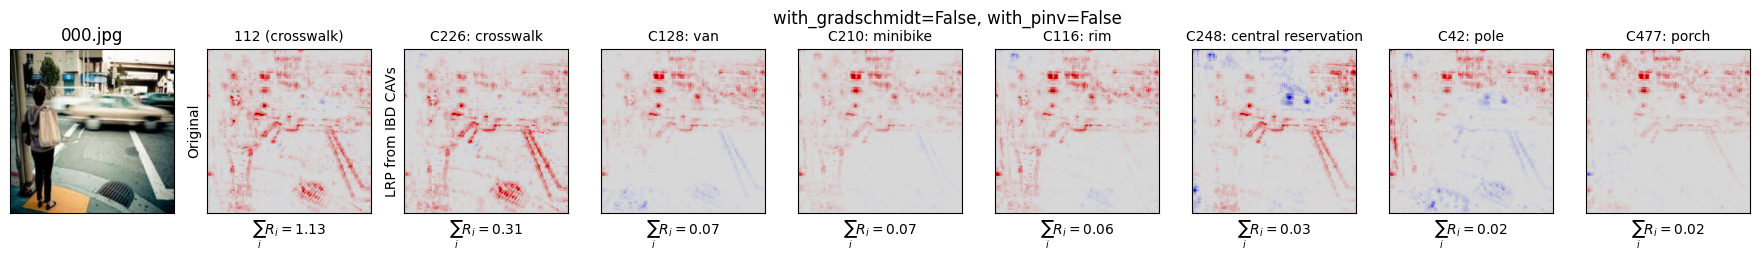

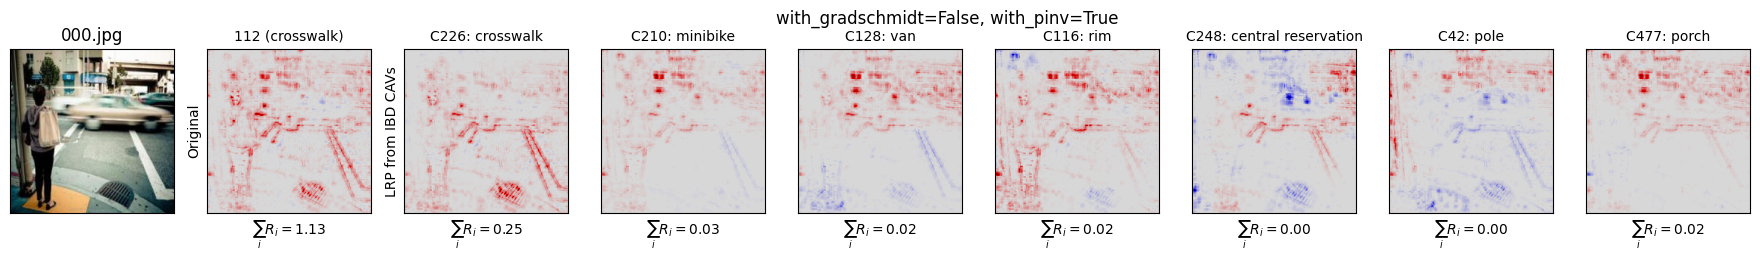

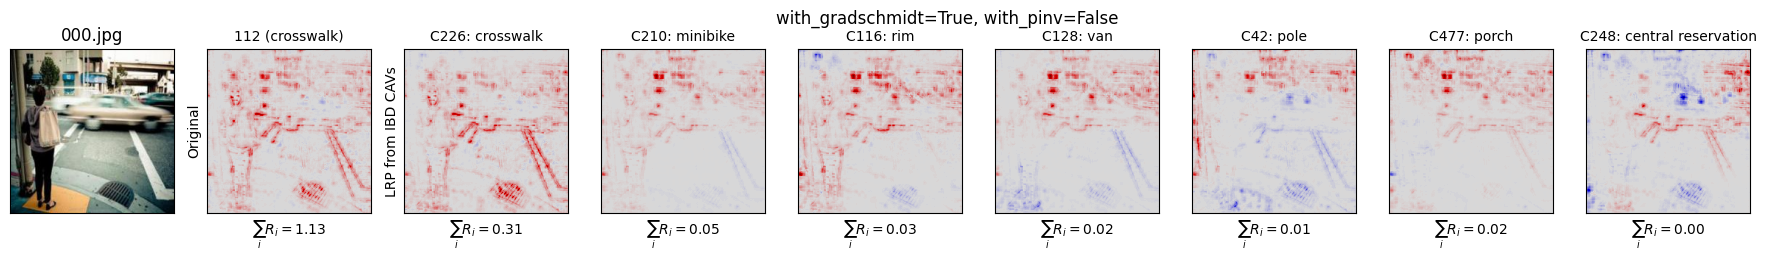

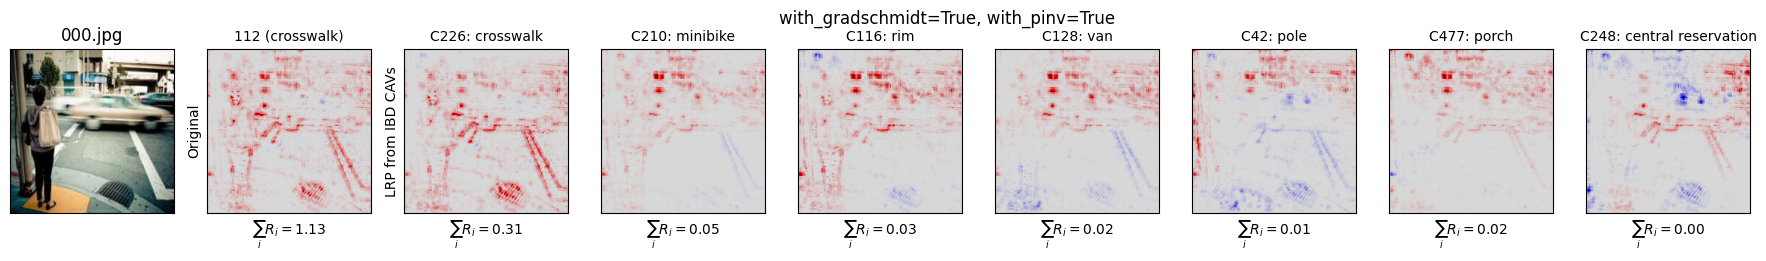

In [19]:
def ano():

    for with_gramschmidt in [False, True]:
        for with_pinv in [False, True]:

            explain_with_basis(
                path = "../components/sample_images/000.jpg",
                target = 112,
                with_pinv=with_pinv,
                with_gramschmidt=with_gramschmidt
            )
            
ano()

In [ ]:
def ano():

    for path, target in [
        ("../components/sample_images/000.jpg", 112),
        ("../components/sample_images/000.jpg", 158),
        ("../components/sample_images/000.jpg", 319),

        ("../components/sample_images/005.jpg", 215),
        ("../components/sample_images/009.jpg", 222),
        ("../components/sample_images/010.jpg", 310),
        ("../components/sample_images/027.jpg", 150),
        ("../components/sample_images/045.jpg", 20),
        ("../components/sample_images/025.jpg", 66),
    ]:
        explain_with_basis(path, target, with_gramschmidt=False, with_pinv=True)
ano()

----- compatible concepts of label=112 ----
> cix=226: crosswalk
> cix=210: minibike
> cix= 42: pole
> cix=116: rim
> cix=477: porch
> cix=248: central reservation
> cix=128: van
----- compatible concepts of label=158 ----
> cix=549: service station
> cix= 42: pole
> cix= 58: headlight
> cix=480: gas pump
> cix=116: rim
> cix=376: fridge
> cix=305: cloud
----- compatible concepts of label=319 ----
> cix= 30: sidewalk
> cix= 58: headlight
> cix= 46: streetlight
> cix=620: temple
> cix=128: van
> cix=210: minibike
> cix=226: crosswalk
----- compatible concepts of label=215 ----
> cix= 77: armchair
> cix=155: fireplace
> cix=141: inside arm
> cix= 66: shade
> cix= 49: sofa
> cix=145: frame
> cix=119: back pillow


In [ ]:
print(f"finished at {datetime.now()}")